In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [2]:
# Step 1: Load the Data
df = pd.read_csv('microsoft_stocks.csv')

In [3]:
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-01-12,47.540001,46.360001,47.419998,46.599998,23651900.0,40.786396
1,2015-01-13,47.910000,46.060001,46.970001,46.360001,35270600.0,40.576340
2,2015-01-14,46.240002,45.619999,45.959999,45.959999,29719600.0,40.226257
3,2015-01-15,46.380001,45.410000,46.220001,45.480000,32750800.0,39.806129
4,2015-01-16,46.279999,45.169998,45.310001,46.240002,35695300.0,40.471313


In [4]:
# Summary of the variables
print("\nSummary statistics:")
print(df.describe())


Summary statistics:
              High          Low         Open        Close        Volume  \
count  1925.000000  1925.000000  1925.000000  1925.000000  1.925000e+03   
mean    140.301455   137.482982   138.934888   138.967096  3.009687e+07   
std      89.000722    87.030367    88.066413    88.062951  1.397862e+07   
min      40.740002    39.720001    40.340000    40.290001  7.425600e+06   
25%      61.410000    60.810001    61.009998    61.119999  2.150010e+07   
50%     108.739998   106.290001   107.860001   107.639999  2.669610e+07   
75%     215.000000   210.360001   213.100006   212.830002  3.426400e+07   
max     349.670013   342.200012   344.619995   343.109985  1.691640e+08   

         Adj Close  
count  1925.000000  
mean    134.947514  
std      89.136791  
min      35.359890  
25%      56.459160  
50%     102.966743  
75%     209.119339  
max     340.882812  


In [5]:
#Check if there are missing values. We can see all the values are zero. This indicates that no variables has missing value

print("\nCheck for missing values:")
print(df.isnull().sum())


Check for missing values:
Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64


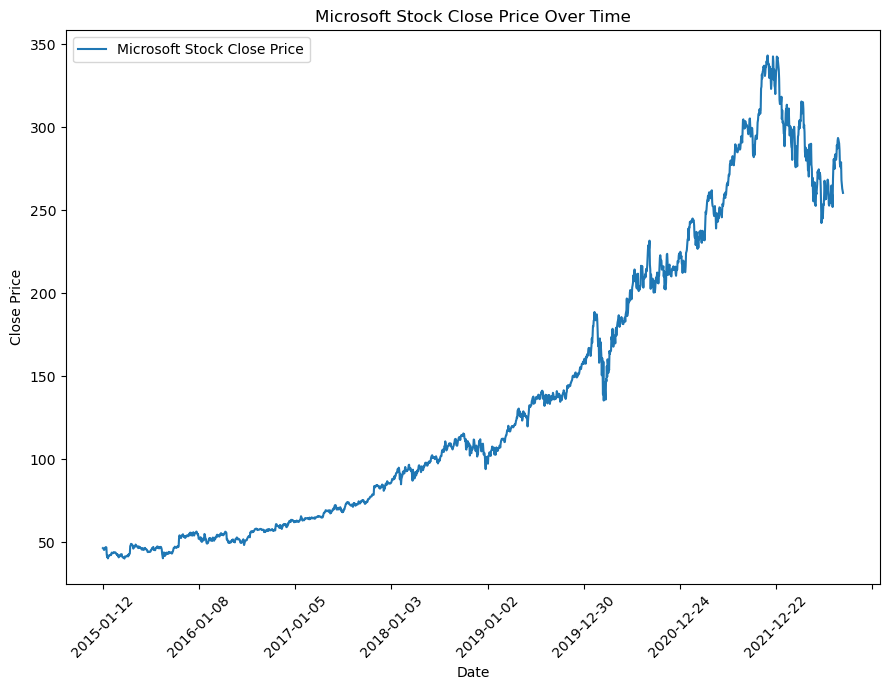

In [6]:
plt.figure(figsize=(9, 7))
plt.plot(df['Date'], df['Close'], label='Microsoft Stock Close Price')
plt.title('Microsoft Stock Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')

# Rotate x-axis labels
plt.xticks(rotation=45)

# Set a tick interval, e.g., every 6 months
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))

plt.legend()
plt.tight_layout()  # Adjust the layout to make room for the rotated labels
plt.show()

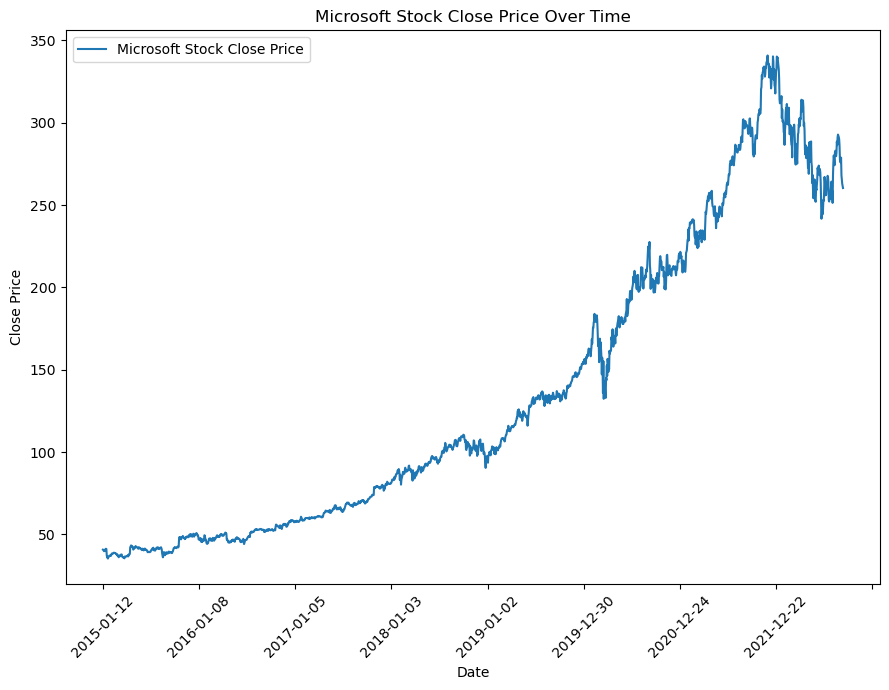

In [7]:
plt.figure(figsize=(9, 7))
plt.plot(df['Date'], df['Adj Close'], label='Microsoft Stock Close Price')
plt.title('Microsoft Stock Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')

# Rotate x-axis labels
plt.xticks(rotation=45)

# Set a tick interval, e.g., every 6 months
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))

plt.legend()
plt.tight_layout()  # Adjust the layout to make room for the rotated labels
plt.show()

In [8]:
# Step 2: Prepare the Data
# Ensure that the 'Date' column is properly handled and converted to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Sort the data by date (just in case)
df = df.sort_values('Date')

# Drop other columns if we're only focusing on closing prices for simplicity
data = df[['Close']]


In [9]:
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-01-12,47.540001,46.360001,47.419998,46.599998,23651900.0,40.786396
1,2015-01-13,47.910000,46.060001,46.970001,46.360001,35270600.0,40.576340
2,2015-01-14,46.240002,45.619999,45.959999,45.959999,29719600.0,40.226257
3,2015-01-15,46.380001,45.410000,46.220001,45.480000,32750800.0,39.806129
4,2015-01-16,46.279999,45.169998,45.310001,46.240002,35695300.0,40.471313


In [10]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Convert back to DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=['Close'])


In [11]:
#scaled_df.head()

In [12]:
# Function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i + seq_length].values)  # Use .iloc to access the rows by index
        y.append(data.iloc[i + seq_length].values)  # Predict the next value after the sequence
    return np.array(X), np.array(y)


In [13]:
# Define sequence length and create sequences
sequence_length = 90  # Using the last 90 days to predict the next day
X, y = create_sequences(scaled_df, sequence_length)

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [14]:
# Reshape the data to match LSTM input requirements
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [15]:
# Step 3: Build the LSTM Model with Tuning Improvements
models = Sequential()
models.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], 1)))  # Increased units
models.add(Dropout(0.4))  
models.add(LSTM(units=64, return_sequences=False))  # Increased units
models.add(Dropout(0.4))  # Increased dropout rate to prevent overfitting
models.add(Dense(units=32, activation='relu'))  # Added activation function to the dense layer
models.add(Dense(units=1))


In [16]:
# Compile the model
models.compile(optimizer='adam', loss='mean_squared_error')

In [17]:
# Step 4: Train the Model
history = models.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)  # Increased epochs

Epoch 1/50
46/46 [==============================] - 13s 146ms/step - loss: 0.0086 - val_loss: 0.0013
Epoch 2/50
46/46 [==============================] - 5s 110ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 3/50
46/46 [==============================] - 5s 102ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 4/50
46/46 [==============================] - 5s 110ms/step - loss: 0.0014 - val_loss: 0.0077
Epoch 5/50
46/46 [==============================] - 5s 111ms/step - loss: 0.0011 - val_loss: 0.0166
Epoch 6/50
46/46 [==============================] - 5s 110ms/step - loss: 0.0010 - val_loss: 0.0181
Epoch 7/50
46/46 [==============================] - 5s 104ms/step - loss: 0.0011 - val_loss: 0.0174
Epoch 8/50
46/46 [==============================] - 5s 98ms/step - loss: 8.9701e-04 - val_loss: 0.0140
Epoch 9/50
46/46 [==============================] - 8s 177ms/step - loss: 8.9643e-04 - val_loss: 0.0069
Epoch 10/50
46/46 [==============================] - 9s 204ms/step - loss: 8.4278e-04 - val_

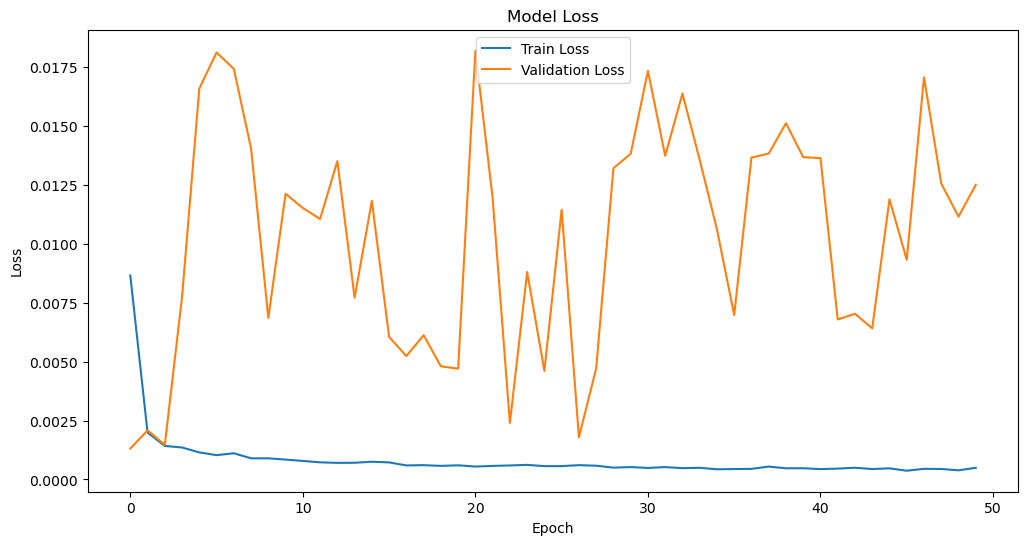

In [18]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

12/12 [==============================] - 1s 59ms/step


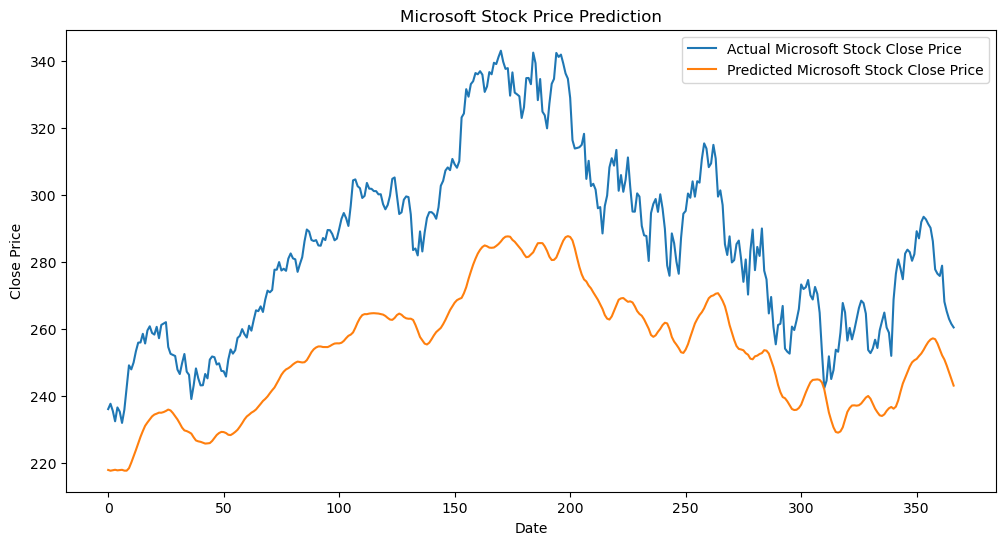

In [30]:

# Step 5: Evaluate and Make Predictions
predictions = models.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Inverse transform the actual values for comparison
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Microsoft Stock Close Price')
plt.plot(predictions, label='Predicted Microsoft Stock Close Price')
plt.title('Microsoft Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

1/1 [==============================] - 0s 143ms/step


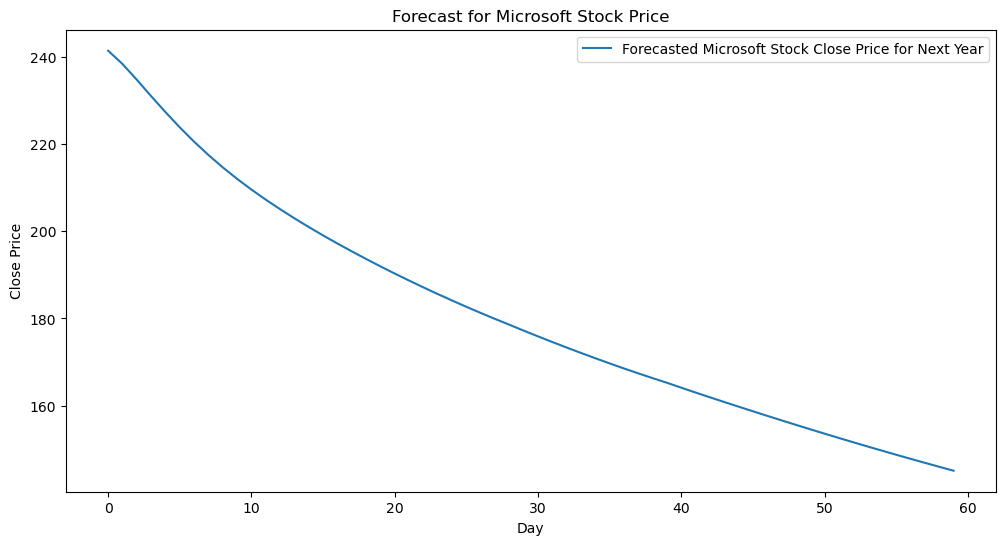

In [20]:
# Step 6: Forecasting the Next Year
# Use the last `sequence_length` days of data to start the prediction
last_sequence = scaled_data[-sequence_length:]
predictions_for_year = []

for _ in range(60):
    # Predict the next value
    pred = models.predict(last_sequence.reshape(1, sequence_length, 1))
    predictions_for_year.append(pred[0, 0])
    
    # Update the sequence with the new prediction
    last_sequence = np.append(last_sequence[1:], pred, axis=0)

# Inverse transform the predictions to the original scale
predictions_for_year = scaler.inverse_transform(np.array(predictions_for_year).reshape(-1, 1))

# Plot the forecast for the next year
plt.figure(figsize=(12, 6))
plt.plot(predictions_for_year, label='Forecasted Microsoft Stock Close Price for Next Year')
plt.title('Forecast for Microsoft Stock Price')
plt.xlabel('Day')
plt.ylabel('Close Price')
plt.legend()
plt.show()



12/12 [==============================] - 1s 59ms/step


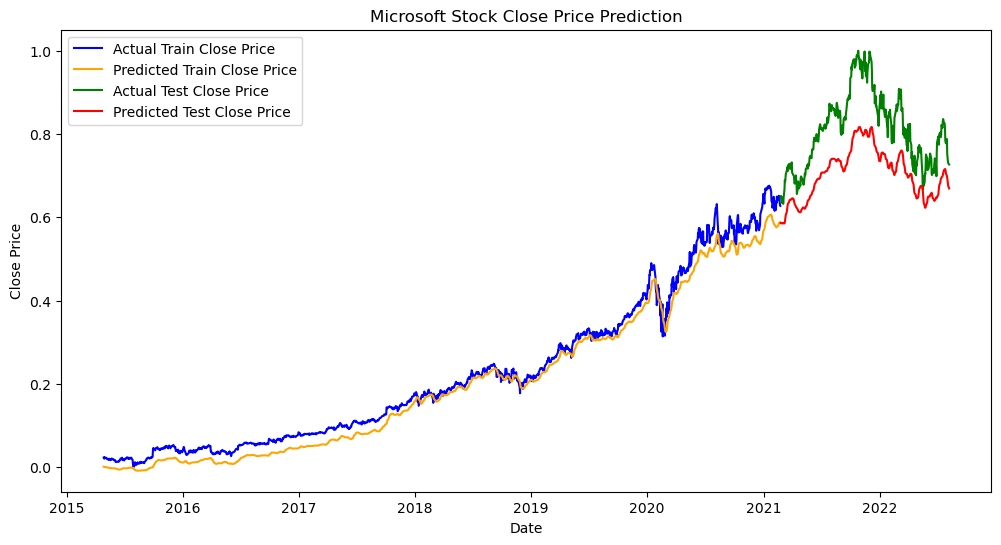

In [21]:
# Predict the values
y_pred_trains = models.predict(X_train).flatten()
y_pred_tests = models.predict(X_test).flatten()

# Split dates into train and test based on the original data
datetrain_sizes = int(len(df['Date']) * 0.8)
Xdate_trains = df['Date'][:datetrain_sizes][-len(y_pred_trains):]  # Use only the last len(y_pred_train) dates
Xdate_tests = df['Date'][datetrain_sizes:datetrain_sizes + len(y_pred_tests)]  # Use only the first len(y_pred_test) dates

# Plotting the data
plt.figure(figsize=(12, 6))

# Training data plot
plt.plot(Xdate_trains, y_train.flatten()[-len(y_pred_trains):], label='Actual Train Close Price', color='blue')
plt.plot(Xdate_trains, y_pred_trains, label='Predicted Train Close Price', color='orange')

# Testing data plot
plt.plot(Xdate_tests, y_test.flatten(), label='Actual Test Close Price', color='green')
plt.plot(Xdate_tests, y_pred_tests, label='Predicted Test Close Price', color='red')

plt.title('Microsoft Stock Close Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

## COMBINE TWO MODELS TOGETHER

###  Bidirectional LSTM and GRU

In [22]:
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

# Step 3: Build the Improved Model
model = Sequential()

# Add Bidirectional LSTM Layers
model.add(Bidirectional(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], 1))))
model.add(Dropout(0.4))  # Dropout to prevent overfitting
model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model.add(Dropout(0.3))  # Dropout to prevent overfitting

# Add GRU Layer
model.add(GRU(units=32, return_sequences=False))
model.add(Dropout(0.3))

# Add Dense Layers
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [23]:
# Early Stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [24]:
# Step 4: Train the Model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stopping])

Epoch 1/100
46/46 [==============================] - 86s 575ms/step - loss: 0.0123 - val_loss: 0.0017
Epoch 2/100
46/46 [==============================] - 14s 317ms/step - loss: 0.0020 - val_loss: 0.0048
Epoch 3/100
46/46 [==============================] - 15s 323ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 4/100
46/46 [==============================] - 16s 339ms/step - loss: 0.0015 - val_loss: 0.0096
Epoch 5/100
46/46 [==============================] - 16s 347ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 6/100
46/46 [==============================] - 15s 327ms/step - loss: 0.0010 - val_loss: 0.0112
Epoch 7/100
46/46 [==============================] - 14s 302ms/step - loss: 0.0010 - val_loss: 0.0050
Epoch 8/100
46/46 [==============================] - 14s 316ms/step - loss: 0.0011 - val_loss: 0.0132
Epoch 9/100
46/46 [==============================] - 13s 290ms/step - loss: 8.2704e-04 - val_loss: 0.0113
Epoch 10/100
46/46 [==============================] - 14s 316ms/step - loss: 8

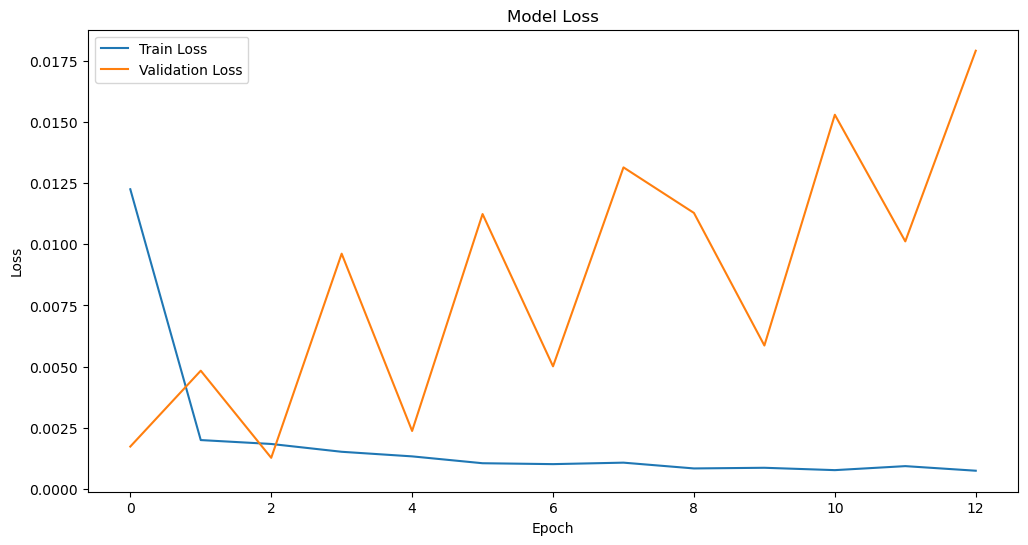

In [25]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
# Step 5: Evaluate and Make Predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Inverse transform the actual values for comparison
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

12/12 [==============================] - 12s 99ms/step


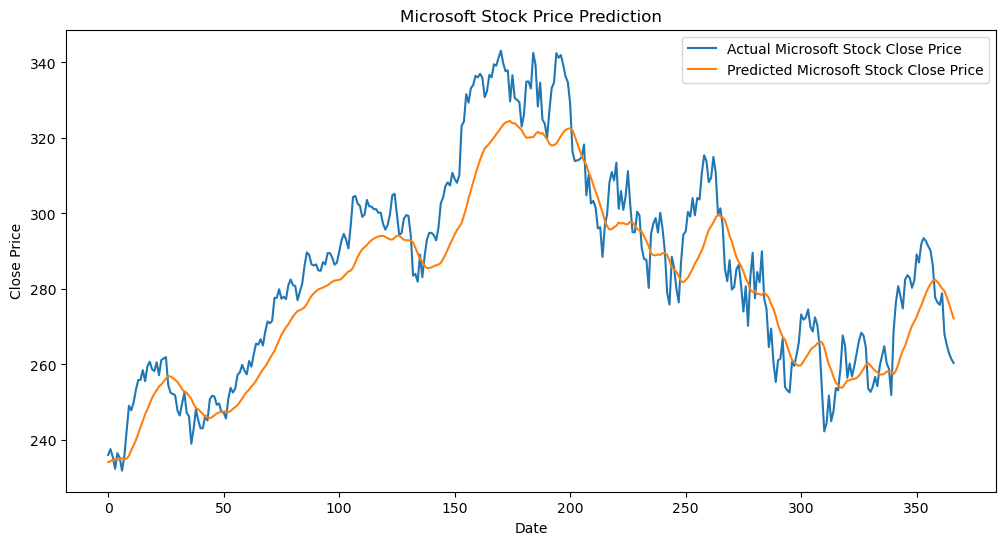

In [27]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Microsoft Stock Close Price')
plt.plot(predictions, label='Predicted Microsoft Stock Close Price')
plt.title('Microsoft Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [28]:
# Step 6: Forecasting the Next Year
# Use the last `sequence_length` days of data to start the prediction
last_sequence = scaled_data[-sequence_length:]
predictions_for_year = []

for _ in range(60):  # Forecasting 60 days ahead
    # Predict the next value
    pred = model.predict(last_sequence.reshape(1, sequence_length, 1))
    predictions_for_year.append(pred[0, 0])
    
    # Update the sequence with the new prediction
    last_sequence = np.append(last_sequence[1:], pred, axis=0)

# Inverse transform the predictions to the original scale
predictions_for_year = scaler.inverse_transform(np.array(predictions_for_year).reshape(-1, 1))

1/1 [==============================] - 0s 91ms/step


12/12 [==============================] - 1s 89ms/step


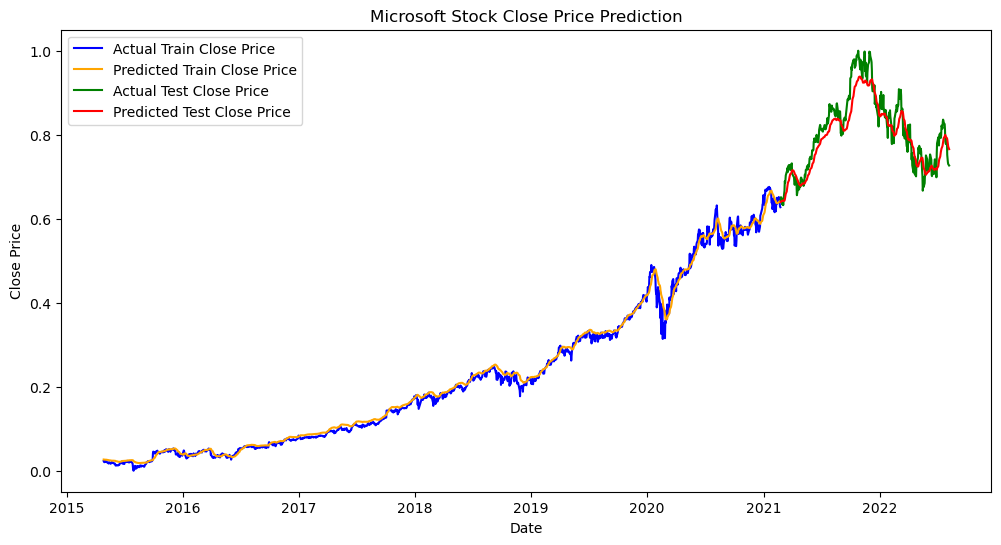

In [29]:
# Predict the values
y_pred_train = model.predict(X_train).flatten()
y_pred_test = model.predict(X_test).flatten()

# Split dates into train and test based on the original data
datetrain_size = int(len(df['Date']) * 0.8)
Xdate_train = df['Date'][:datetrain_size][-len(y_pred_train):]  # Use only the last len(y_pred_train) dates
Xdate_test = df['Date'][datetrain_size:datetrain_size + len(y_pred_test)]  # Use only the first len(y_pred_test) dates

# Plotting the data
plt.figure(figsize=(12, 6))

# Training data plot
plt.plot(Xdate_train, y_train.flatten()[-len(y_pred_train):], label='Actual Train Close Price', color='blue')
plt.plot(Xdate_train, y_pred_train, label='Predicted Train Close Price', color='orange')

# Testing data plot
plt.plot(Xdate_test, y_test.flatten(), label='Actual Test Close Price', color='green')
plt.plot(Xdate_test, y_pred_test, label='Predicted Test Close Price', color='red')

plt.title('Microsoft Stock Close Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()